In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import os
from pygifsicle import optimize
import imageio
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 200)

from matplotlib.lines import Line2D

In [2]:
## Download the three shapefiles
geo_df= gpd.read_file("shapefiles/ne_10m_admin_1_states_provinces.shp")
geo_df2 = gpd.read_file("shapefiles/ne_10m_admin_0_disputed_areas.shp")
cities_df= gpd.read_file("shapefiles/ne_10m_populated_places.shp")

## Lower names of columns
geo_df2.columns = [x.lower() for x in geo_df2.columns]
cities_df.columns = [x.lower() for x in cities_df.columns]

## Add a column to seperate cities from regions
cities_df['city'] = True
geo_df2['city'] = ""
geo_df['city'] = ""

## Concat the columns together
geo_df = pd.concat([geo_df,geo_df2,cities_df])

geo_df =  geo_df[['iso_a2','name','geometry','name_en', 'adm1_code','iso_3166_2','city']]
geo_df[['name_en',"adm1_code","iso_3166_2"]] = geo_df[['name_en',"adm1_code","iso_3166_2"]].fillna("")
manual_df = pd.read_excel('datafile.xlsx',keep_default_na=False)
geo_df = geo_df.merge(manual_df, on=['iso_a2','name','name_en', 'adm1_code','iso_3166_2','city'],how='right')
date_cols = sorted(set(geo_df.columns) - {'iso_a2','name','name_en', 'adm1_code','iso_3166_2','geometry','city'})
geo_df.head()
geo_df[geo_df.geometry==None]

,iso_a2,name,geometry,name_en,adm1_code,iso_3166_2,city,20200101,20200102,20200103,...,20200307,20200308,20200309,20200310,20200311,20200312,20200313,20200314,20200315,20200316
4738,AI,,None,,AIA+99?,AI-X00,,green,green,green,...,green,green,green,green,green,green,green,green,green,green
4739,AQ,,None,,ATA+99?,AQ-X02~,,grey,grey,grey,...,grey,grey,grey,grey,grey,grey,grey,grey,grey,grey
4740,CO,,None,,COL+99?,CO-X01~,,yellow,yellow,yellow,...,yellow,yellow,yellow,yellow,yellow,yellow,yellow,orange,orange,orange
4741,KI,,None,,KIR+99?,KI-X02~,,grey,grey,grey,...,grey,grey,grey,grey,grey,grey,grey,grey,grey,grey
4742,MA,Chefchaoen,None,Chefchaoen,,,True,yellow,yellow,yellow,...,yellow,yellow,yellow,yellow,yellow,yellow,yellow,,0,0
4743,MX,,None,,MEX+99?,MX-X01~,,yellow,yellow,yellow,...,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow
4744,RU,,None,,RUS+99?,RU-X01~,,yellow,yellow,yellow,...,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow
4745,VE,,None,,VEN+99?,VE-X01~,,orange,orange,orange,...,orange,orange,orange,orange,orange,orange,orange,orange,orange,orange


In [3]:
colors = ['green','yellow','orange','red']
colors_and_grey = colors+['grey']
unknown = "grey"
city_marker_size = 0.3

In [4]:
def create_world_map(datenr,show_plot,dpi=100):
    column_name = date_cols[datenr-1]
    fig, ax = plt.subplots(figsize=(30,9))
    
    normal_df = geo_df[(geo_df['iso_a2']!="-99") & (geo_df['city']=="") & (geo_df[column_name].isin(colors_and_grey))]
    normal_df.plot(color=normal_df[column_name],ax=ax,legend=True,edgecolor='grey',linewidth=0.05)
    
    disputed_df = geo_df[(geo_df['iso_a2']=="-99") & (geo_df['city']=="") & (geo_df[column_name].isin(colors_and_grey))]
    disputed_df.plot(color=disputed_df[column_name],ax=ax,legend=True,edgecolor='grey',linewidth=0.05)

    cities_df = geo_df[(geo_df['city']==True) & (geo_df[column_name].isin(colors))]
    cities_df.plot(color=cities_df[column_name],ax=ax, legend=True,marker='o',markersize=city_marker_size)    


    legend_elements = [Line2D([0], [0], marker='o', color='green', label="No special security risks",markerfacecolor='g', markersize=15),
                      Line2D([0], [0], marker='o', color='yellow', label="Watch out, security risks",markerfacecolor='yellow', markersize=15),
                      Line2D([0], [0], marker='o', color='orange', label="Only necessary travels",markerfacecolor='orange', markersize=15),
                      Line2D([0], [0], marker='o', color='red', label="Don't travel",markerfacecolor='r', markersize=15)]
    ax.legend(handles=legend_elements, loc='center left')
    ax.set_facecolor('white')
    plt.axis('off');
    plt.title("%s-%s-%s" %(column_name[-2:],column_name[4:-2],column_name[:4]));
    if dpi< 200:
        plt.savefig('maps_for_gif/%s.jpg' %column_name, bbox_inches = 'tight',pad_inches = 0, dpi=dpi);
    else:
        plt.savefig('most_recent_map.jpg', bbox_inches = 'tight',pad_inches = 0, dpi=dpi);
    if show_plot:
        plt.show()
    plt.close()
interact(create_world_map, datenr=widgets.IntSlider(min=1, max=len(date_cols), step=1, value=1),show_plot=fixed(True),dpi=fixed(100));

interactive(children=(IntSlider(value=1, description='datenr', max=76, min=1), Output()), _dom_classes=('widge…

In [5]:
## Create a world map for every date
for i in tqdm(range(1,len(date_cols)+1)):
     create_world_map(i, False)

## Turn all images into one gif
os.remove('movie.gif')
filenames=sorted(os.listdir('maps_for_gif'))
with imageio.get_writer('movie.gif', mode='I',duration=0.2) as writer:
    for filename in tqdm(filenames):
        image = imageio.imread('maps_for_gif/'+filename)
        writer.append_data(image)
## Compress the gif
optimize("movie.gif","compressed.gif")

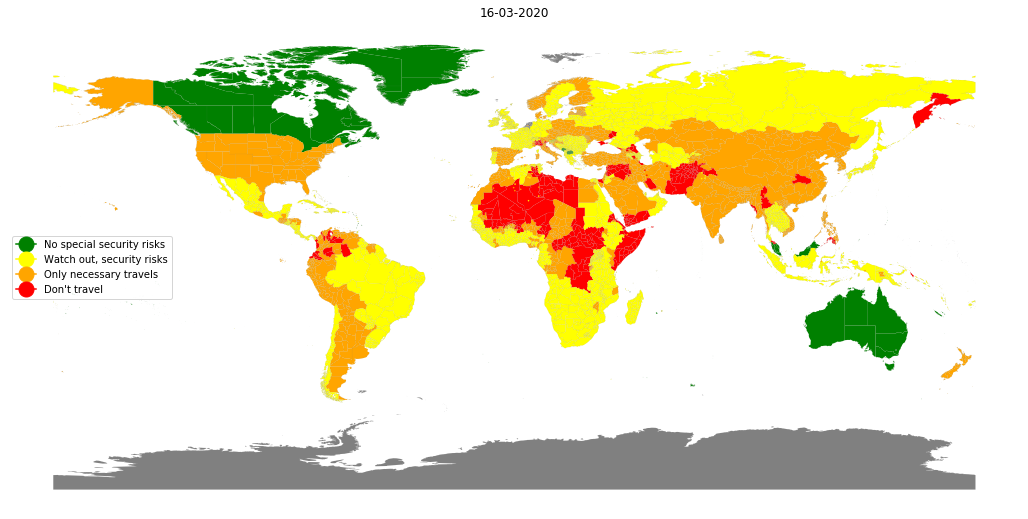

In [6]:
# Save latest map in HQ
create_world_map(len(date_cols),True,dpi=1080)


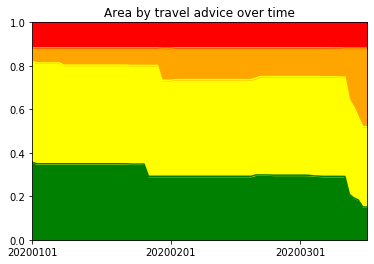

In [7]:
## Get color over time
## Not counting cities
from collections import defaultdict


dictt = defaultdict(lambda: defaultdict(int))
geo_df = geo_df.dropna(subset=['geometry'])
geo_df= geo_df.to_crs({'init': 'epsg:3035'})
geo_df["area"] = geo_df['geometry'].area / 10**6
for i in tqdm(range(1,len(date_cols)+1)):
    column_name = date_cols[i-1]
    for c in colors:
        dictt[column_name][c] = geo_df[(geo_df[column_name] == c)& (geo_df['city']=="")]["area"].sum()

area_df = pd.DataFrame(dictt).T[colors]
area_df = area_df.divide(area_df.sum(axis=1), axis=0)
ax = area_df.plot.area(colors=colors,legend=False)
ax.set_ylim((0,1))
ax.set_xticks([n for n,x in enumerate(area_df.index) if x.endswith('01')])
ax.set_xticklabels([x for n,x in enumerate(area_df.index) if x.endswith('01')])
plt.title("Area by travel advice over time");
    
plt.savefig('area_over_time.jpg', bbox_inches = 'tight',pad_inches = 0, dpi=1080);